In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
from setup.univ_setup import univ_setup, filt_na, filt_byval
from setup.utils import merge
from factor_mining.combine_factors import combine_factors
from factor_mining.factor_preprocessing import *

from factor_mining.Mark0 import alpha_four_factors

In [3]:
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, silent=False)
filt_na(univ)
import warnings
warnings.filterwarnings("ignore")


Setup R3000 universe
use existing binary file
0.464102 seconds


In [4]:
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)
factor_names = list(factors.keys())


Calculate factors


In [5]:
# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])
print('Done')

Filt the untradables
Done


In [6]:
# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Scale each factor
Winsorize with +/- 3 std
Done


In [8]:
from setup.utils import *
fx = stack(factor_exp_mat)

In [10]:
from sklearn.linear_model import lars_path

In [11]:
X, y = fx[factor_names], fx['f_log_ret_1']

In [12]:
alphas, active, coefs = lars_path(np.asarray(X), np.asarray(y))

In [19]:
alphas

array([ 0.00116585,  0.00060021,  0.00043632,  0.00011446,  0.        ])

In [13]:
active

[1, 0, 3, 2]

In [14]:
coefs

array([[ 0.        ,  0.        , -0.00010786, -0.00032159, -0.00039966],
       [ 0.        , -0.00071711, -0.0008709 , -0.00116476, -0.00139741],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.00023872],
       [ 0.        ,  0.        ,  0.        ,  0.00038698,  0.00053351]])

In [15]:
factor_names

['beta', 'vol60', 'log_market_cap', 'momentum']

In [17]:
fx.sort(['date', 'ticker'], inplace=True)

In [18]:
fx.head()

,date,beta,vol60,log_market_cap,momentum,ticker,f_log_ret_1,industry
0,2010-10-22,-0.224473,0.144488,0.863998,-0.902130,A,0.001438,Industrial
1,2010-10-22,0.940182,0.141778,0.924623,-0.664963,AA,0.032489,Basic Materials
2,2010-10-22,-0.495098,-0.452531,-0.829125,-1.276094,AAN,0.063482,"Consumer, Non-cyclical"
3,2010-10-22,-1.281713,-0.847346,0.192582,1.848355,AAP,0.056678,"Consumer, Cyclical"
4,2010-10-22,-0.419095,-0.708857,2.999999,0.398551,AAPL,-0.021335,Technology


In [20]:
import seaborn as sns

In [22]:
cm = np.corrcoef(X, rowvar=0)

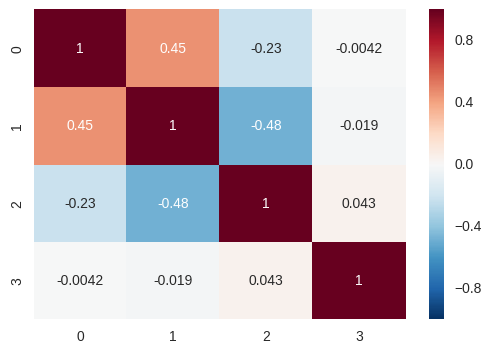

In [24]:
%matplotlib inline
sns.heatmap(cm, annot=True)

In [30]:
cut = int(fx.shape[0] * 2/3)
dataIS = fx.iloc[:cut,:]
dataOS = fx.iloc[cut:,:]

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
lr = LinearRegression()

In [33]:
XIS, yIS = dataIS[factor_names], dataIS['f_log_ret_1']
XOS, yOS = dataOS[factor_names], dataOS['f_log_ret_1']

In [34]:
lr.fit(XIS, yIS)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
y_pred = lr.predict(XOS)

In [36]:
from sklearn.metrics import r2_score

In [37]:
r2_score(yOS, y_pred)

-0.00092182915026195467

In [38]:
r2_score(yIS, lr.predict(XIS))

0.00050616407369052929

In [39]:
lr.coef_

array([-0.00028344, -0.00106307, -0.0002387 ,  0.00060636])

In [40]:
factor_names

['beta', 'vol60', 'log_market_cap', 'momentum']